# Example 5.9 (An ellipse format chart for overtime hours)

In [1]:
import pathlib
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chapter_5_utils import plot_control_ellipse

In [2]:
def load_data() -> pd.DataFrame:
    fpth = pathlib.Path(r'..\..\data\Table5.8.xlsx')
    return pd.read_excel(fpth)

In [3]:
df = load_data()
df.head(3)

,Legal Appearances Hours,Extraordinary Event Hours,Holdover Hours,COA Hours,Meeting Hours
0,3387,2200,1181,14861,236
1,3109,875,3532,11367,310
2,2670,957,2502,13329,1182


In [4]:
# X is n x p = 16 x 2.
X = df.iloc[:, 0:2].to_numpy()
n, p = X.shape

In [5]:
xbar = np.mean(X, axis=0).reshape(p, 1)
S = np.cov(X.T, ddof=1)

In [6]:
alpha = 0.01
crit = scipy.stats.chi2(df=p).ppf(q=1-alpha)

Compute ${\left(\textbf{x} - \bar{\textbf{x}}\right)}^{\prime} \textbf{S}^{-1} {\left(\textbf{x} - \bar{\textbf{x}}\right)}$

In [7]:
Sinv = np.linalg.inv(S)
stat_dist = lambda x: (x.reshape(1,p) - xbar.T) @ Sinv @ (x.reshape(p,1) - xbar)
dist = np.array([stat_dist(X[i,:]).flatten() for i in range(X.shape[0])])

How many values are larger than $\chi_{p=2}^{2}\left(0.01\right)$?

In [8]:
print(f'There are {(dist > crit).sum()} observations larger than {crit:.2f}.')

There are 1 observations larger than 9.21.


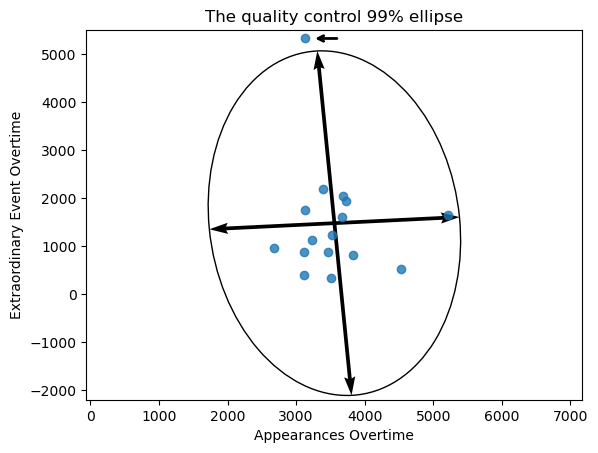

In [9]:
my_plot, ax = plot_control_ellipse(
    df.iloc[:,[0,1]], alpha)
my_plot.scatter(X[:,0], X[:,1], alpha=0.8)
my_plot.annotate(
    '',
    xy=tuple(X[X[:,1] > 5000].squeeze() + [100, 0]),
    xytext=tuple(X[X[:,1] > 5000].squeeze()+[500, 0]),
    arrowprops=dict(facecolor='black', arrowstyle='->',linewidth=2)
)
ax.set_ylim(-2200, 5500)
ax.set_aspect('equal')
ax.set_aspect(aspect=0.7, adjustable='datalim')
ax.set_title('The quality control 99% ellipse')
my_plot.xlabel('Appearances Overtime')
my_plot.ylabel('Extraordinary Event Overtime')
my_plot.show()


In [10]:
cl = xbar[1] + np.array([-1, 1]) * (3 * np.sqrt(S[1,1]))

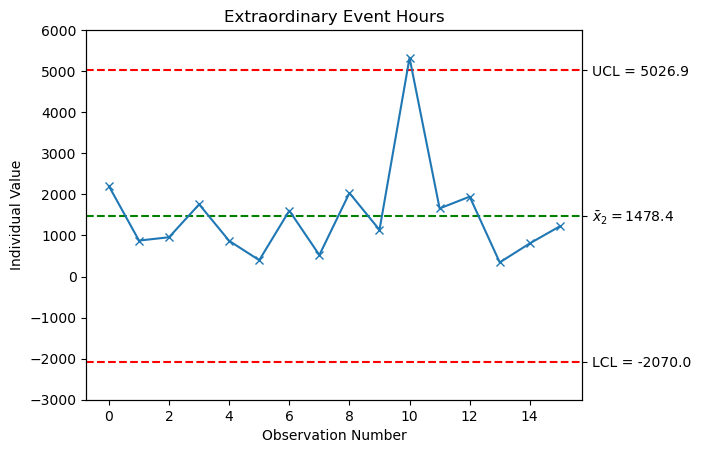

In [11]:
plt.figure()
ax = plt.gca()
plt.axhline(y=cl[0], color='r', linestyle='--')
plt.axhline(y=xbar[1].item(), color='g', linestyle='--')
plt.axhline(y=cl[1], color='r', linestyle='--')
plt.plot(X[:,1], marker='x')
plt.ylim([-3000, 6000])
plt.title('Extraordinary Event Hours')
plt.xlabel('Observation Number')
plt.ylabel('Individual Value')
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()) 
ax2.set_yticks([cl[0], xbar[1].item(), cl[1]])
ax2.set_yticklabels([f'LCL = {cl[0]:.1f}', f'$\\bar{{x}}_{2} = {xbar[1].item():.1f}$', f'UCL = {cl[1]:.1f}'])
plt.show()